In [1]:
# Initialization
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hddm
import numpy as np
import pickle
from patsy import dmatrix
from kabuki.analyze import gelman_rubin
from kabuki.analyze import post_pred_gen
from kabuki.utils import concat_models
import pathlib

In [2]:
print (hddm.__version__)

1.0.1RC


In [3]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [4]:
data_F.head(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
0,114192,2,0.984893,6,e,1,BlockFvN,1,A,2,1,2
1,114192,6,0.926056,6,e,1,BlockFvN,1,B,1,2,2
2,114192,9,0.854008,6,e,1,BlockFvN,1,B,1,2,2
3,114192,11,0.881858,6,e,1,BlockFvN,1,B,1,2,2
4,114192,12,0.918875,6,e,1,BlockFvN,1,B,1,2,2
5,114192,13,0.906791,6,e,1,BlockFvN,1,B,1,2,2
6,114192,15,0.949124,6,f,0,BlockFvN,1,A,2,1,2
7,114192,16,0.839553,6,e,1,BlockFvN,1,A,2,1,2
8,114192,17,1.006603,6,f,0,BlockFvN,1,A,2,1,2
9,114192,24,0.855258,6,f,0,BlockFvN,1,A,2,1,2


In [5]:
data_F.tail(10)

,subj_idx,trial,rt,stim_frame,key_response,response,blockname,task,stim_file,HSF_emo,LSF_emo,congruence
9740,993849,330,0.601870,6,n,0,BlockF_1,2,B,1,2,2
9741,993849,331,0.681040,6,b,1,BlockF_1,2,A,2,1,2
9742,993849,332,0.599069,6,b,1,BlockF_1,2,B,1,2,2
9743,993849,334,0.551520,6,n,0,BlockF_1,2,A,2,1,2
9744,993849,336,0.538108,6,b,1,BlockF_1,2,B,1,2,2
9745,993849,339,0.776732,6,b,1,BlockF_1,2,A,2,1,2
9746,993849,341,0.503375,6,n,0,BlockF_1,2,A,2,1,2
9747,993849,343,0.515187,6,n,0,BlockF_1,2,B,1,2,2
9748,993849,344,0.614084,6,b,1,BlockF_1,2,A,2,1,2
9749,993849,349,0.615294,6,b,1,BlockF_1,2,B,1,2,2


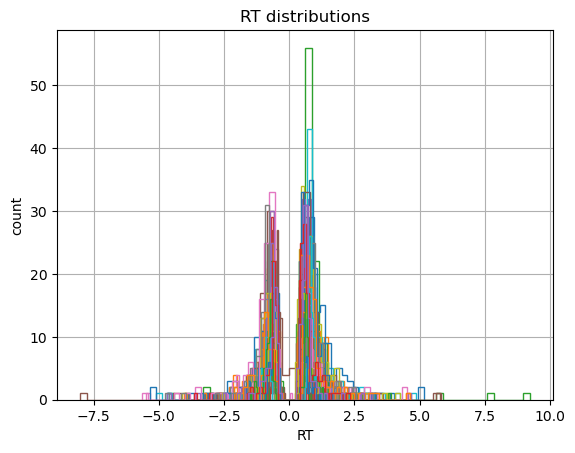

In [6]:
# Plot the RT distributions for the upper (+) and lower (-) bounds
# first flip the RT for the lower bound using flip error, i.e., the lower bound RT to make it negative
data_F = hddm.utils.flip_errors(data_F)
fig = plt.figure()
ax = fig.add_subplot(111, xlabel = 'RT', ylabel = 'count', title = 'RT distributions')
for i, subj_data in data_F.groupby('subj_idx'):
    subj_data.rt.hist(bins = 50, histtype = 'step', ax = ax)
    
plt.savefig('./testrt.pdf')

In [7]:
# instantiate model object (no need to call flip_errors() before passing it).
# tailoring an individual hierarchical DDM around dataset.
dependancies = {'v':['HSF_emo'],'z':['task']}
m3 = hddm.HDDM(data_F, include=('z', 'v', 'a', 't'), depends_on = dependancies, p_outlier = 0.05, informative = False)
# find good starting point. helps with convergence
m3.find_starting_values()
# start drawing 500 samples and discarding 20 as burn-in, every 5th thinned
m3.sample(5000, burn=2500, thin = 2, dbname = './m3_traces.db', db = 'pickle')

No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 2116.5 sechddm sampling elpased time:  2116.747 s


In [8]:
m3.save('./m3_traces')

In [9]:
stats = m3.gen_stats()
m3.print_stats()

                      mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                 1.354795  0.030151  1.298376  1.332998  1.354032  1.375465  1.415743  0.000841
a_std             0.227912   0.02343  0.185347  0.211054  0.226561  0.244192  0.278451  0.000808
a_subj.114192     1.425034  0.070043   1.29535  1.376699  1.422169  1.468409  1.574718  0.002633
a_subj.136867     1.341475  0.053341  1.243914  1.300808  1.340106  1.380388  1.444049  0.001704
a_subj.152317     1.295002  0.054112  1.197403  1.256951  1.293242  1.330701  1.407268  0.001638
a_subj.160211     1.168786  0.056534  1.068223  1.127687  1.165585  1.204831  1.293722   0.00155
a_subj.185005     1.320377  0.061861  1.204513  1.277948  1.318377  1.360421  1.449819  0.001862
a_subj.207436      1.54641  0.075182  1.399876  1.498357  1.546052  1.595356  1.697555  0.002544
a_subj.215147     1.366919  0.062586   1.24912   1.32457  1.366891  1.406611  1.496909  0.002058
a_subj.243315     1.348862   0

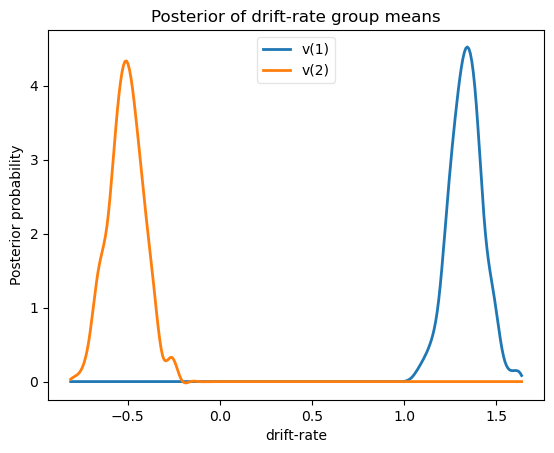

In [10]:
v_1, v_2 = m3.nodes_db.node[['v(1)','v(2)']]
hddm.analyze.plot_posterior_nodes([v_1,v_2])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('./m3dr.pdf', bbox_inches ="tight")

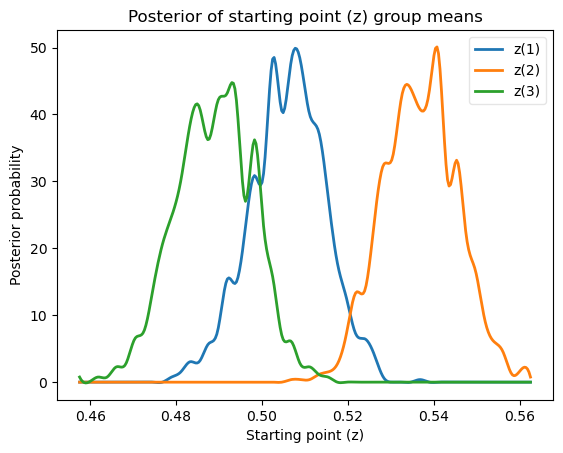

In [11]:
# Extract posterior nodes for z (starting point) across the three levels
z_1, z_2, z_3 = m3.nodes_db.node[['z(1)', 'z(2)', 'z(3)']]

# Plot the posterior distributions
hddm.analyze.plot_posterior_nodes([z_1, z_2, z_3])

# Add labels and title
plt.xlabel('Starting point (z)')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point (z) group means')

# Save the figure
plt.savefig('./m3_starting_point_z.pdf', bbox_inches="tight")

# Show the plot
plt.show()

In [12]:
print ("P(v(1) > v(2)) = ", (v_1.trace() > v_2.trace()).mean())
print ("P(v(2) > v(1)) = ", (v_2.trace() > v_1.trace()).mean())

P(v(1) > v(2)) =  1.0
P(v(2) > v(1)) =  0.0


In [13]:
# Pairwise comparisons for the starting point (z) across the three levels
print("P(z(1) > z(2)) = ", (z_1.trace() > z_2.trace()).mean())
print("P(z(2) > z(1)) = ", (z_2.trace() > z_1.trace()).mean())
print("P(z(1) > z(3)) = ", (z_1.trace() > z_3.trace()).mean())
print("P(z(3) > z(1)) = ", (z_3.trace() > z_1.trace()).mean())
print("P(z(2) > z(3)) = ", (z_2.trace() > z_3.trace()).mean())
print("P(z(3) > z(2)) = ", (z_3.trace() > z_2.trace()).mean())

P(z(1) > z(2)) =  0.0048
P(z(2) > z(1)) =  0.9952
P(z(1) > z(3)) =  0.9176
P(z(3) > z(1)) =  0.0824
P(z(2) > z(3)) =  1.0
P(z(3) > z(2)) =  0.0
